In [1]:
import cv2 
import numpy as np 
from PIL import Image
from utils.FloorplanToBlenderLib import *

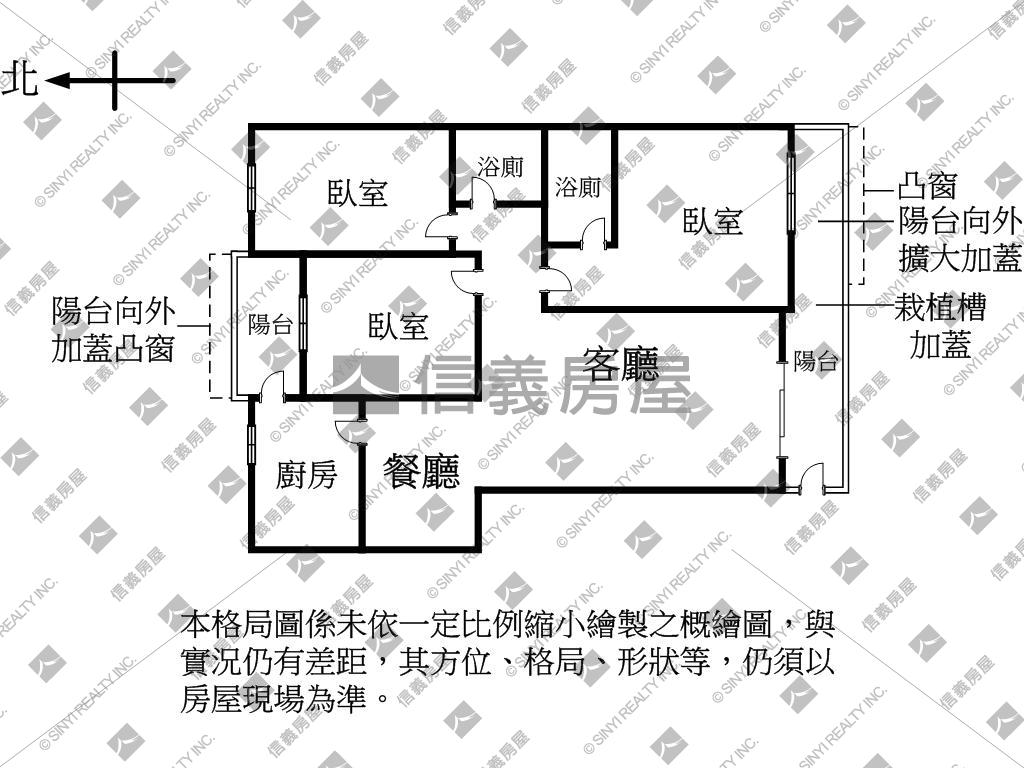

In [2]:
img = cv2.imread("images/test5.jpg")
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
display(Image.fromarray(img))
# display(Image.fromarray(gray_img))

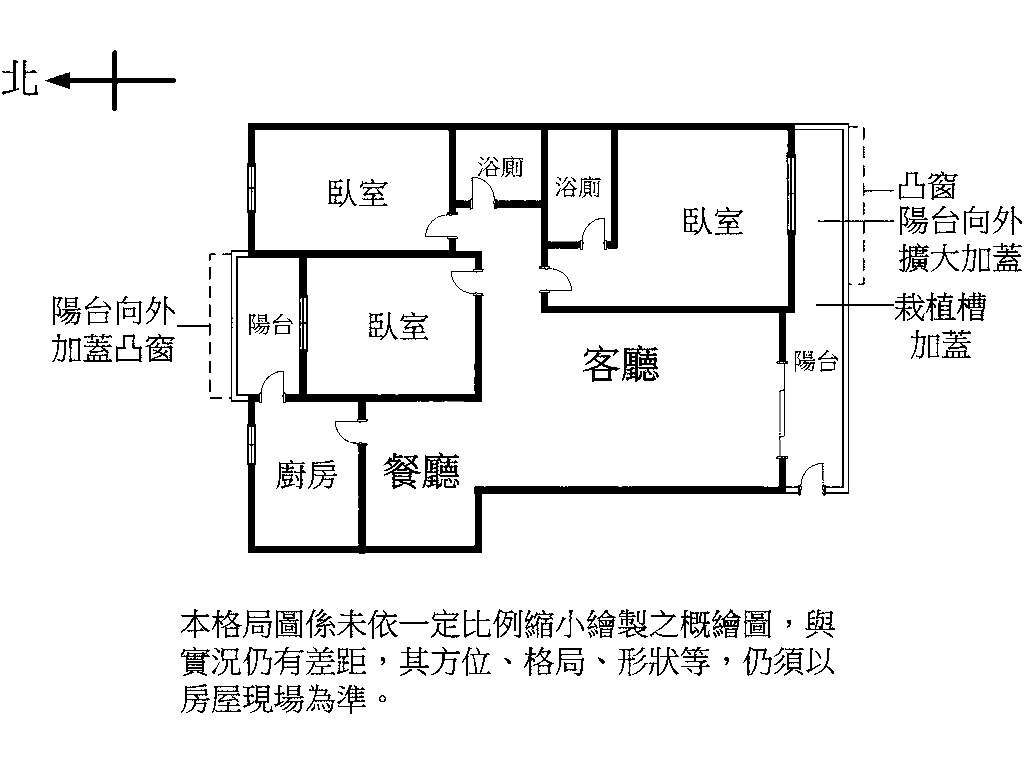

In [3]:
mask = detect.remove_noise(gray_img, 128)
# remove = ~mask
# display(Image.fromarray(mask))

output = cv2.bitwise_not(gray_img, mask)
delete_watermark = ~output
display(Image.fromarray(delete_watermark))
# cv2.imwrite('without_watermark.png', delete_watermark)

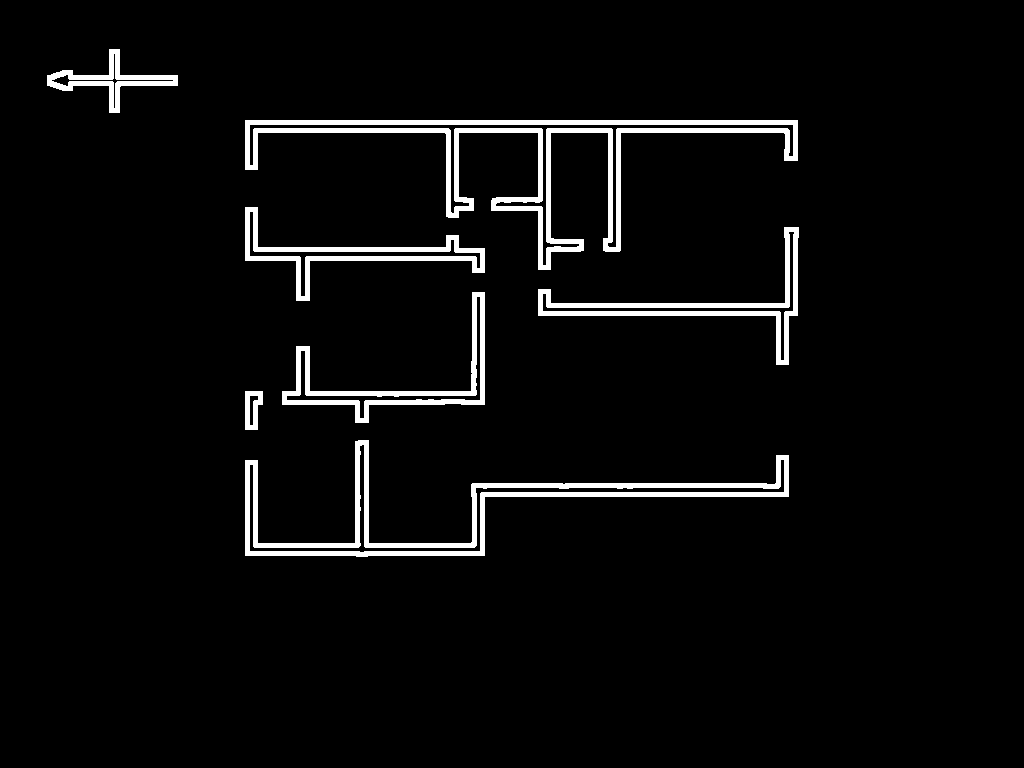

In [4]:
test1 = detect.wall_filter(delete_watermark)
test2 = ~test1
# cv2.imshow("test1", test1)

display(Image.fromarray(test1))
# display(Image.fromarray(test2))

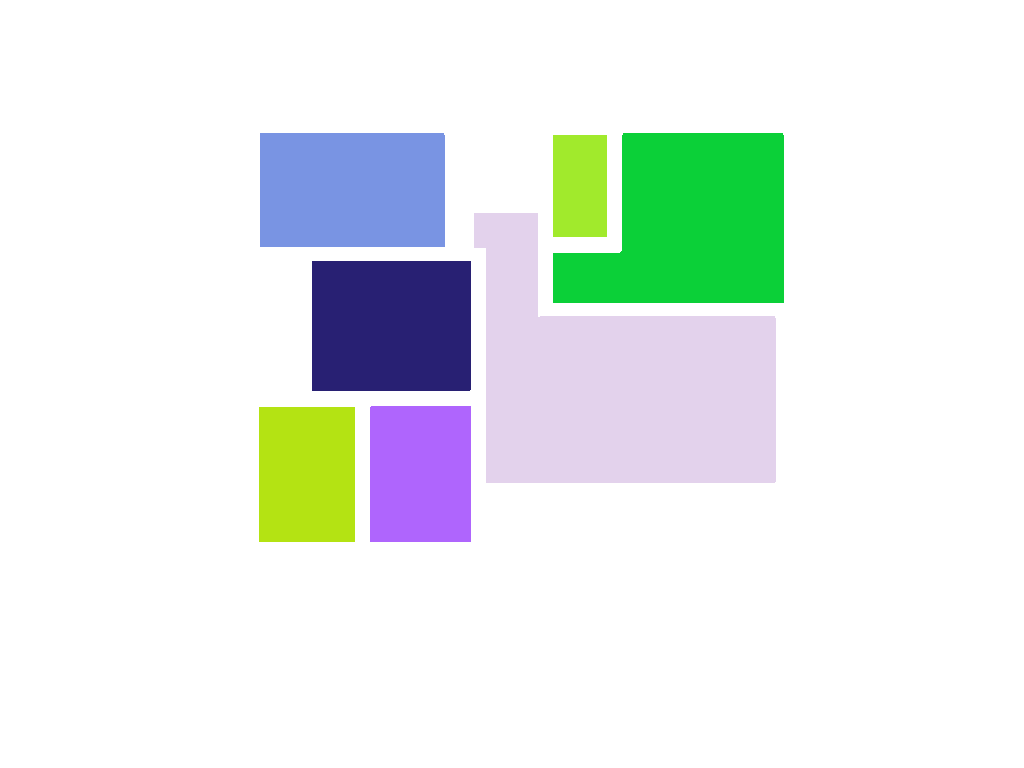

In [5]:
rooms, color_rooms = detect.find_rooms(test2)
color_rooms_white = ~color_rooms
# print(type(rooms))
# display(Image.fromarray(color_rooms))
display(Image.fromarray(color_rooms_white))

## Get different room

In [6]:
img=color_rooms_white
img.shape

(768, 1024, 3)

In [7]:
testarr = np.ones(img.shape[0:2], dtype=np.int32)
testarr.shape

(768, 1024)

In [8]:
img2 = img.astype(np.int32)
testarr = img2[:,:,0]+255*img2[:,:,1]+(255**2)*img2[:,:,2]
print(testarr[0,0])
print(img[0,0,:])

16646655
[255 255 255]


In [9]:
# for white background
unique = np.unique(testarr)[::-1]

# for black background
#unique = np.unique(testarr)

unique

array([16646655, 16477255, 15399677, 14798536,  7486075,  3694451,
        2920931,  1293540])

In [10]:
testarr2 = np.zeros(img.shape[0:2], dtype=np.int32)
for ind, i in enumerate(unique):
    testarr2 = np.where(testarr == i,ind,testarr2)

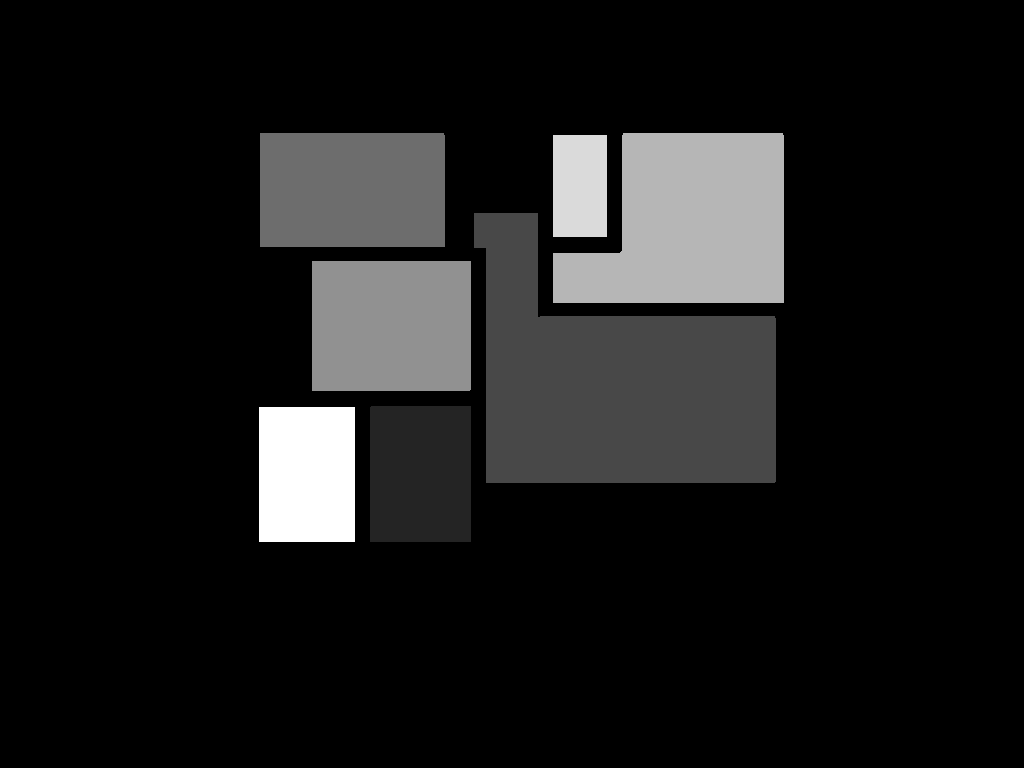

(768, 1024)

In [11]:
# Testing block
testarr3 = testarr2*(255/7)
testarr3 =testarr3.astype(np.uint8)
display(Image.fromarray(testarr3))
testarr3.shape

### Door detect

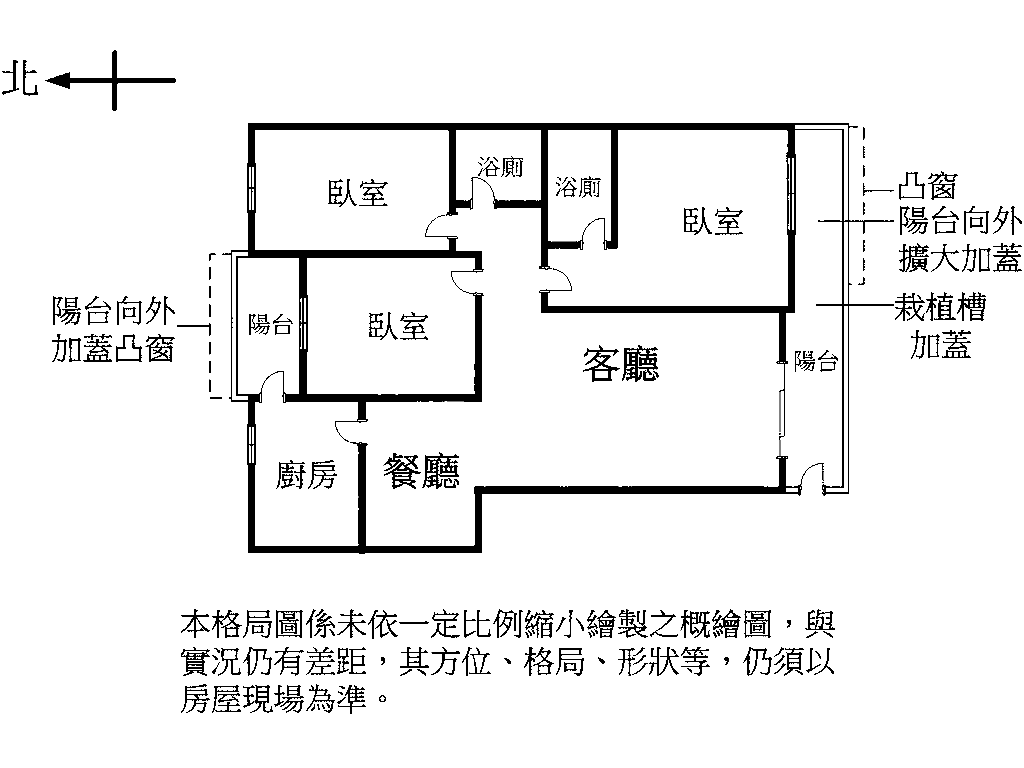

In [12]:
img = cv2.cvtColor(delete_watermark, cv2.COLOR_GRAY2BGR)
gray = delete_watermark
display(Image.fromarray(img))
# display(Image.fromarray(gray_img))

In [13]:
# convert to binary image
thresh=cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY )[1]

#  Morphological reconstruction (delete labels)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
marker = cv2.dilate(thresh,kernel,iterations = 1)
while True:
    tmp=marker.copy()
    marker=cv2.erode(marker, kernel2)
    marker=cv2.max(thresh, marker)
    difference = cv2.subtract(tmp, marker)
    if cv2.countNonZero(difference) == 0:
        break


# only walls
se=cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
walls=cv2.morphologyEx(marker, cv2.MORPH_CLOSE, se)
walls=cv2.erode(walls, kernel2,iterations=2)

# other objects
other=cv2.compare(marker,walls, cv2.CMP_GE)
other=cv2.bitwise_not(other)

# find connected components and select by size and area
output = cv2.connectedComponentsWithStats(other, 4, cv2.CV_32S)
num_labels = output[0]
labels = output[1]
stats=output[2]
centroids = output[3]
test = img
print('left|top|width|height|area')
for i in range(num_labels):
    left, top, width, height, area = stats[i]
    print(left, top, width, height, area)

left|top|width|height|area
0 0 1024 768 782346
45 79 4 3 7
798 123 96 373 1667
786 161 10 68 402
247 170 9 39 204
470 177 27 23 63
493 201 1 1 1
446 212 2 4 5
425 218 32 21 54
580 218 25 32 70
222 250 25 152 236
236 256 11 140 316
539 266 1 3 3
451 269 32 27 68
551 268 1 1 1
539 268 33 25 63
299 301 9 47 283
776 361 2 3 4
776 365 12 94 214
260 371 25 32 70
335 421 22 21 47
247 430 9 32 166
350 442 7 2 10
359 442 1 1 1
789 463 35 33 131


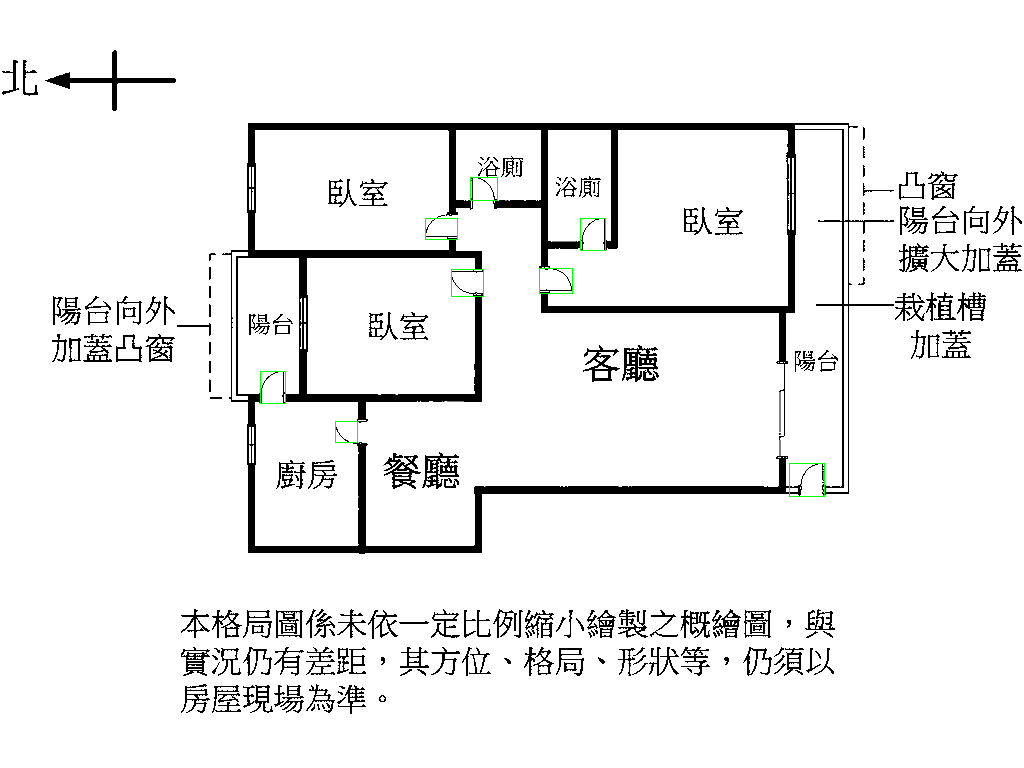

In [14]:
for i in range(num_labels):
    left, top, width, height, area = stats[i]
    if width > 10 and height > 10 and abs(width - height) < 12:
        cv2.rectangle(test,(left, top), (left+width, top+height), (0,255,0))

# cv2.imwrite('doors.png', test)
display(Image.fromarray(test))